<font size="20"> Heart Disease </font>

INTRODUCTION:





PRELIMINARY EXPLORATORY DATA ANALYSIS:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read.csv(file = url) |>
rename(age=X63.0,
       sex=X1.0,
       chest_pain=X1.0.1,
       resting_blood_pressure=X145.0,
       cholesterol=X233.0,
       fasting_blood_sugar=X1.0.2,
       resting_electrocardiographic_results=X2.0,
       max_heart_rate=X150.0,
       exercise_induced_angina=X0.0,
       S_depression_induced=X2.3,
       slope_of_peak_exercise=X3.0,
       major_vessels=X0.0.1,
       thal=X6.0,
       heart_disease_diagnosis=X0)
heart_data


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


In [2]:
#Splitting data into training and testing 
heart_split <- initial_split(heart_data, prop=0.75, strata=resting_blood_pressure)
    heart_train <- training(heart_split)
    heart_test <- testing(heart_split)

In [3]:
#Selected columns (sex, resting blood pressure, and heart_disease_diagnosis) from heart data.
heart_train_selected <- select(heart_train, sex, age, cholesterol, resting_blood_pressure, heart_disease_diagnosis) |>
                        arrange(sex, age, resting_blood_pressure)
heart_train_selected

sex,age,cholesterol,resting_blood_pressure,heart_disease_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,37,215,120,0
0,39,199,94,0
0,39,220,138,0
0,41,306,126,0
0,42,265,102,0
0,42,209,120,0
0,43,213,122,0
0,43,341,132,2
0,44,141,108,0


In [4]:
#Reporting the number of rows with missing data (NA's).
#Data shows that there are zero rows with missing data.
heart_train %>%
map_df(is.na) %>%
map_df(sum)

age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
#We found that the total number of rows in the heart train dataset is 224, and the number of rows after removing for
#any missing rows is also 224. This confirms that there are no rows with missing data in this dataset. 
nrow(heart_train)
nrow(heart_train %>% na.omit())

[1] 224

[1] 224

In [6]:
#Reported number of observations for each class. It is found that there is the greatest amount of observations 
#found for the heart disease diagnosed as 0 and the least amount of observations for the heart disease diagnosed as 4.
count <- group_by(heart_train_selected, heart_disease_diagnosis) |>
            summarize(total=n())
count

heart_disease_diagnosis,total
<int>,<int>
0,124
1,38
2,29
3,24
4,9


In [7]:
#The table below reports the average cholesterol level for males(1) and females(0). Not a great amount of 
#difference is found for the cholesterol level between males and females. There is a difference of 19.39.
sex_vs_cholesterol <- group_by(heart_train_selected, sex) |>
                      summarize(cholesterol=mean(cholesterol, na.rm=TRUE))
sex_vs_cholesterol

sex,cholesterol
<dbl>,<dbl>
0,263.6324
1,238.4167


In [8]:
#The table below reports the average heart disease diagnosis (on a scale of 0-4) for males(1) and females(0).
#It is found that the heart disease diagnosis level is slightly greater for males (~1.03) compared to females (~0.51).
sex_vs_heart_disease <- group_by(heart_train_selected, sex) |>
                        summarize(heart_disease_diagnosis=mean(heart_disease_diagnosis, na.rm=TRUE))
sex_vs_heart_disease

sex,heart_disease_diagnosis
<dbl>,<dbl>
0,0.5441176
1,1.0705128


In [9]:
#The table below reports the average resting blood pressure (mm Hg) for each heart disease diagnosis level (0-4). 
#There is generally a slight increase in resting blood pressure as the heart disease diagnosis level increases. 
heart_disease_vs_resting_blood_pressure <- group_by(heart_train_selected, heart_disease_diagnosis) |>
                                summarize(resting_blood_pressure=mean(resting_blood_pressure, na.rm=TRUE))
heart_disease_vs_resting_blood_pressure

heart_disease_diagnosis,resting_blood_pressure
<int>,<dbl>
0,128.5645
1,134.8947
2,132.3103
3,139.0000
4,133.2222


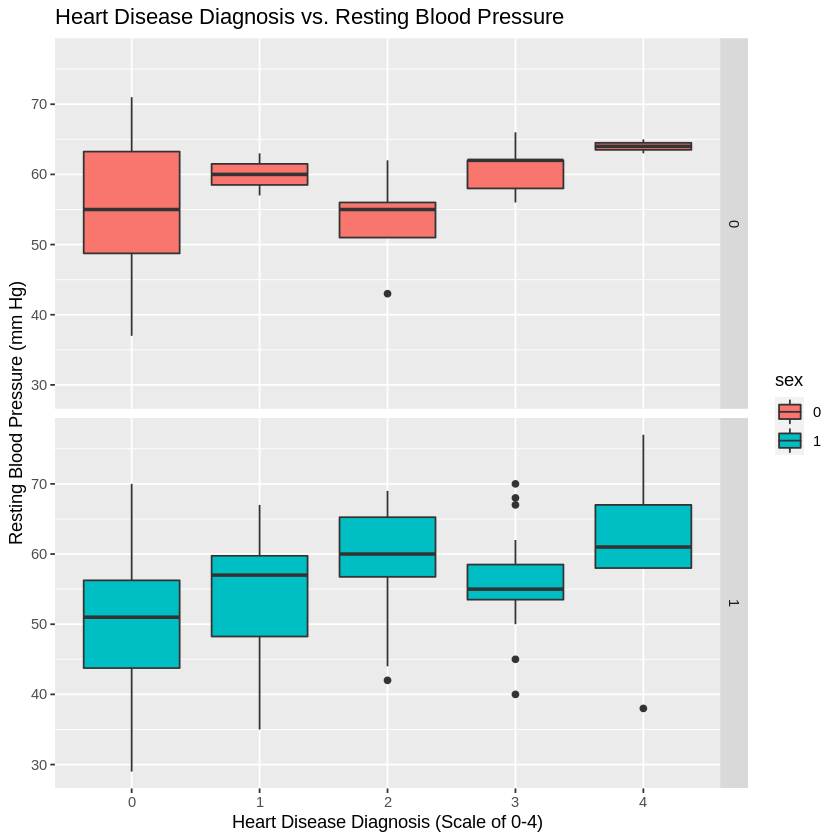

In [21]:
# Plot of heart disease diagnosis on a scale of 0-4 versus resting blood pressure (mm Hg) in men and women. 
# The graph shows that heart disease diagnosis level has a weak positive correlation with resting blood pressure for 
# both male (1) and female (2). 
# An increase in the heart disease diagnosis level correlates to a slight increase in resting blood pressure amount.
# There is a stronger relationship between heart disease diagnosis and resting blood pressure for males, but also  
# more outliers in the data. 
plot_heart_disease_vs_resting_blood_pressure <- heart_train_selected |>
                            mutate(heart_disease_diagnosis = as.factor(heart_disease_diagnosis)) |>
                            mutate(sex = as.factor(sex)) |>
                            ggplot(aes(x=heart_disease_diagnosis, y=age, fill=sex)) +
                                 geom_boxplot() +
                                 labs(x="Heart Disease Diagnosis (Scale of 0-4)", y="Resting Blood Pressure (mm Hg)", title="Heart Disease Diagnosis vs. Resting Blood Pressure", )+
                            facet_grid(sex~.)
plot_heart_disease_vs_resting_blood_pressure

<font size="5"> Methods </font>